<a href="https://colab.research.google.com/github/CobaMasa/PythonKerasDeeplearning/blob/main/chapter6_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# List 6-45: Prepare imdb data
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_tset) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences.')
print(len(x_test), 'test sequences.')

print('\nPad sequence (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences.
25000 test sequences.

Pad sequence (samples x time)
x_train shape:  (25000, 500)
x_test shape:  (25000, 500)


In [2]:
# List 6-46: Train & val simple 1D CNN 
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model

inputs = Input(shape=(max_len))
x = Embedding(max_features, 128)(inputs)
x = Conv1D(32, 7, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(32, 7, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
prediction = Dense(1)(x)

model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
display(model.summary())
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                

None

Epoch 1/10
157/157 [==============================] - 6s 35ms/step - loss: 1.0050 - acc: 0.5070 - val_loss: 0.6899 - val_acc: 0.5456
Epoch 2/10
157/157 [==============================] - 5s 33ms/step - loss: 0.6736 - acc: 0.6457 - val_loss: 0.6708 - val_acc: 0.6454
Epoch 3/10
157/157 [==============================] - 5s 32ms/step - loss: 0.6302 - acc: 0.7576 - val_loss: 0.6192 - val_acc: 0.7130
Epoch 4/10
157/157 [==============================] - 5s 33ms/step - loss: 0.5365 - acc: 0.8141 - val_loss: 0.4961 - val_acc: 0.7960
Epoch 5/10
157/157 [==============================] - 5s 33ms/step - loss: 0.4102 - acc: 0.8487 - val_loss: 0.4156 - val_acc: 0.8364
Epoch 6/10
157/157 [==============================] - 5s 33ms/step - loss: 0.3427 - acc: 0.8759 - val_loss: 0.4020 - val_acc: 0.8518
Epoch 7/10
157/157 [==============================] - 5s 32ms/step - loss: 0.3021 - acc: 0.8961 - val_loss: 0.4108 - val_acc: 0.8610
Epoch 8/10
157/157 [==============================] - 5s 32ms/step - 

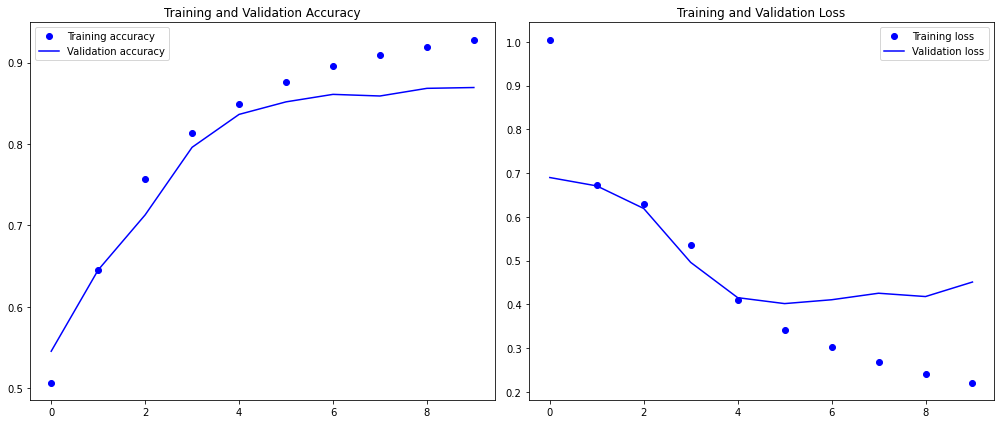

In [3]:
# Plot the results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(10)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# about acc
ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

# about loss
ax[1].plot(epochs, loss, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()

plt.tight_layout()
plt.show();

In [4]:
# List 6-47: Train and val simple 1D CNN with temperature data
## Def some functions to generate data ahead
import os
import numpy as np

path = 'drive/My Drive/Study/PythonKeras/data/jena_climate'
fname = os.path.join(path, 'jena_climate_2009_2016.csv')
with open(fname, 'r') as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

## make float data
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(value) for value in line.split(',')[1:]]
    float_data[i, :] = values

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# List 6-33: Define the generator
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    
    while True:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
        
        else:
            if (i+batch_size) >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples, targets

# List 6-34: Prepares generators of data
lookback = 1440
step = 6
delay = 144
batch_size = 128
some_args = {'lookback': lookback, 'delay': delay, 'batch_size': batch_size, 'step': step}

train_gen  = generator(float_data, min_index=0, max_index=200000, shuffle=True, **some_args)
val_gen = generator(float_data, min_index=200001, max_index=300000, **some_args)
test_gen = generator(float_data, min_index=300001, max_index=None, **some_args)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [5]:
# List 6-47: Train and val simple 1D CNN with temperature data
inputs = Input(shape=(None, float_data.shape[-1]))
x = Conv1D(32, 5, activation='relu')(inputs)
x = MaxPooling1D(3)(x)
x = Conv1D(32, 5, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(32, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
prediction = Dense(1)(x)

model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 13s 26ms/step - loss: 0.4075 - val_loss: 0.4719
Epoch 2/20
500/500 [==============================] - 13s 25ms/step - loss: 0.3585 - val_loss: 0.4628
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.3347 - val_loss: 0.4783
Epoch 4/20
500/500 [==============================] - 13s 25ms/step - loss: 0.3217 - val_loss: 0.4561
Epoch 5/20
500/500 [==============================] - 13s 25ms/step - loss: 0.3084 - val_loss: 0.5316
Epoch 6/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2982 - val_loss: 0.4833
Epoch 7/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2934 - val_loss: 0.4805
Epoch 8/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2860 - val_loss: 0.4686
Epoch 9/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2805 - val_loss: 0.4631
Epoch 10/20
500/500 [==============================] - 12s 25ms/step - loss: 0.275

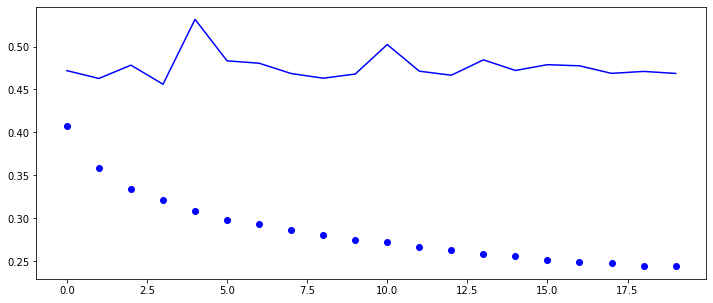

In [6]:
# See loss curves
fig = plt.figure(figsize=(12, 5))
epochs = range(20)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.show();

In [7]:
# List 6-48: Higher resolution Data generators
lookback = 720
step = 3
delay = 144
batch_size = 128
some_args = {'lookback': lookback, 'delay': delay, 'batch_size': batch_size, 'step': step}

train_gen  = generator(float_data, min_index=0, max_index=200000, shuffle=True, **some_args)
val_gen = generator(float_data, min_index=200001, max_index=300000, **some_args)
test_gen = generator(float_data, min_index=300001, max_index=None, **some_args)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:
# List 6-49: 1D CNN & GRU
from tensorflow.keras.layers import GRU
inputs = Input(shape=(None, float_data.shape[-1]))
x = Conv1D(32, 5, activation='relu')(inputs)
x = MaxPooling1D(3)(x)
x = Conv1D(32, 5, activation='relu')(x)
x = GRU(32, dropout=0.1, recurrent_dropout=0.5)(x)
prediction = Dense(1)(x)

model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 143s 286ms/step - loss: 0.3322 - val_loss: 0.2839
Epoch 2/20
500/500 [==============================] - 142s 283ms/step - loss: 0.2983 - val_loss: 0.2916
Epoch 3/20
500/500 [==============================] - 143s 286ms/step - loss: 0.2839 - val_loss: 0.2748
Epoch 4/20
500/500 [==============================] - 144s 288ms/step - loss: 0.2746 - val_loss: 0.2745
Epoch 5/20
500/500 [==============================] - 144s 287ms/step - loss: 0.2671 - val_loss: 0.2746
Epoch 6/20
500/500 [==============================] - 141s 283ms/step - loss: 0.2580 - val_loss: 0.2789
Epoch 7/20
500/500 [==============================] - 140s 280ms/step - loss: 0.2519 - val_loss: 0.2750
Epoch 8/20
500/500 [==============================] - 141s 283ms/step - loss: 0.2481 - val_loss: 0.2867
Epoch 9/20
500/500 [==============================] - 143s 285ms/step - loss: 0.2428 - val_loss: 0.2818
Epoch 10/20
500/500 [==============================] - 142s 285m

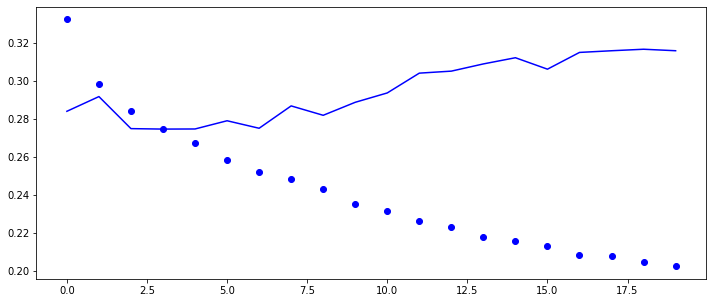

In [9]:
# See loss curves
fig = plt.figure(figsize=(12, 5))
epochs = range(20)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.show();